# Krótkie wprowadzenie do sieci PFN (Prior-data Fitted Networks)

In [1]:
import torch
import torch.nn.functional as F
import numpy as np

from torch import nn
from torch import Tensor

In [2]:
class BinaryClfPFN(nn.Module):
    def __init__(
        self,
        n_features: int,
        n_heads: int,
        d_embed: int,
        d_hidden: int,
        n_layers: int,
    ):
        super().__init__()
        self.encoder_X = nn.Linear(n_features, d_embed)
        self.encoder_y = nn.Linear(1, d_embed)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_embed,
                n_heads,
                d_hidden,
                activation="gelu",
                batch_first=True,
            ),
            n_layers,
        )
        self.decoder = nn.Sequential(
            nn.Linear(d_embed, d_hidden),
            nn.GELU(),
            nn.Linear(d_hidden, 1),
        )

    def get_mask(self, size: int, query_size: int) -> Tensor:
        train_size = size - query_size
        mask = torch.zeros(size, size) == 0
        mask[:, train_size:].zero_()
        mask |= torch.eye(size) == 1
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, X_train: Tensor, y_train: Tensor, test_x: Tensor) -> Tensor:
        """_summary_

        Args:
            X_train (Tensor): Shape `(batch_size, n_samples, n_features)`
            y_train (Tensor): Shape `(batch_size, n_samples, 1         )`
            test_x  (Tensor): Shape `(batch_size, 1        , n_features)`

        Returns:
            Tensor: _description_
        """
        y = self.encoder_y(y_train)  # Shape `(batch_size, n_samples, d_embed)`
        x = self.encoder_X(X_train)  # Shape `(batch_size, n_samples, d_embed)`

        src = torch.cat([x + y, self.encoder_X(test_x)], dim=1)  # Shape `(batch_size, n_samples + 1, d_embed)`
        src_mask = self.get_mask(src.size(1), 1).to(src)
        out = self.transformer(src, src_mask)
        out = self.decoder(out)

        return out[:, -1, :]  # Shape: `(batch_size, n_classes)`

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device.upper()}")

Using device: CUDA


In [4]:
from sklearn.datasets import make_classification


num_epochs = 1_000
batch_size = 256

pfn = BinaryClfPFN(n_features=2, n_heads=4, d_embed=128, d_hidden=256, n_layers=2)
optimizer = torch.optim.Adam(pfn.parameters(), lr=3e-4)

pfn.to(device)
pfn.train()

for epoch in range(num_epochs):
    # --- Sample batch of classification tasks from prior ---
    data = [make_classification(n_features=2, n_redundant=0) for _ in range(batch_size)]
    X, y = zip(*data)
    X, y = np.stack(X), np.stack(y)
    X, y = torch.from_numpy(X).float().to(device), torch.from_numpy(y).float().unsqueeze(-1).to(device)

    X_train, y_train = X[:, :-1, :], y[:, :-1, :]
    test_x, test_y = X[:, -1:, :], y[:, -1, :]

    # --- Train model ---
    logits = pfn(X_train, y_train, test_x)
    loss = F.binary_cross_entropy_with_logits(logits, test_y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"Epoch {epoch:>5d} | Loss {loss.item():.4f}")

Epoch     0 | Loss 0.6804
Epoch     1 | Loss 0.6475
Epoch     2 | Loss 0.6041
Epoch     3 | Loss 0.5544
Epoch     4 | Loss 0.5628
Epoch     5 | Loss 0.5026
Epoch     6 | Loss 0.4942
Epoch     7 | Loss 0.4870
Epoch     8 | Loss 0.5108
Epoch     9 | Loss 0.5460
Epoch    10 | Loss 0.5322
Epoch    11 | Loss 0.4543
Epoch    12 | Loss 0.5278
Epoch    13 | Loss 0.4838
Epoch    14 | Loss 0.5004
Epoch    15 | Loss 0.4685
Epoch    16 | Loss 0.5068
Epoch    17 | Loss 0.4838
Epoch    18 | Loss 0.4664
Epoch    19 | Loss 0.4921
Epoch    20 | Loss 0.4955
Epoch    21 | Loss 0.4818
Epoch    22 | Loss 0.4488
Epoch    23 | Loss 0.3962
Epoch    24 | Loss 0.4084
Epoch    25 | Loss 0.4430
Epoch    26 | Loss 0.4015
Epoch    27 | Loss 0.4054
Epoch    28 | Loss 0.4352
Epoch    29 | Loss 0.3698
Epoch    30 | Loss 0.3045
Epoch    31 | Loss 0.3677
Epoch    32 | Loss 0.3421
Epoch    33 | Loss 0.3500
Epoch    34 | Loss 0.3017
Epoch    35 | Loss 0.3372
Epoch    36 | Loss 0.2644
Epoch    37 | Loss 0.3281
Epoch    38 

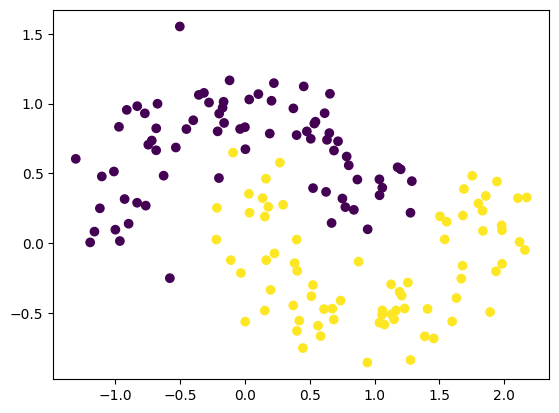

In [7]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_blobs
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

data_x, data_y, *_ = make_moons(n_samples=150, noise=0.2)
_, ax = plt.subplots()
_ = ax.scatter(data_x[:, 0], data_x[:, 1], c=data_y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, train_size=99)

mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

query_size = X_test.shape[0]
X_train = torch.from_numpy(X_train).float().expand(query_size, -1, -1).to(device)
y_train = torch.from_numpy(y_train).float().unsqueeze(-1).expand(query_size, -1, -1).to(device)
test_x = torch.from_numpy(X_test).float().unsqueeze(1).to(device)

pfn.eval()
with torch.no_grad():
    logits: Tensor = pfn(X_train, y_train, test_x).cpu()
    y_pred = logits.sigmoid() > 0.5
    y_pred = y_pred.numpy().flatten()

accuracy_score(y_test, y_pred)

0.8431372549019608